In [22]:
import pycaret
from pycaret.regression import *
import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append("../modules/")

import time_series_CSV_reader as ts

import os
PROJECT_DIR = "ForecastCloudinJapan"
if os.getcwd().split("\\")[-1] == PROJECT_DIR:
    pass
else:
    os.chdir("../")

import pandas as pd
import japanize_matplotlib
import datetime as dt

In [23]:
csv_reader = ts.TimeSeriesCSVReader(2010)
df = csv_reader.load_data()

2022-12-31 00:00:00

In [24]:
df["日付"] = pd.to_datetime(df["日付"])
df_drop = df.drop(["日照時間","全天日射量","視程"],axis=1)
df_drop.head(2)
train = df_drop[df_drop["日付"] < dt.datetime(2020,1,1)]
test = df_drop[df_drop["日付"] > dt.datetime(2020,1,1)]

train_date = train["日付"]
test_date = test["日付"]

train.drop("日付",axis=1,inplace=True)
test.drop("日付",axis=1,inplace=True)

In [25]:
exp1 = setup(train,target="雲量")

,Description,Value
0,session_id,4512
1,Target,雲量
2,Original Data,"(87647, 14)"
3,Missing Values,True
4,Numeric Features,10
5,Categorical Features,3
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(61352, 35)"


In [26]:
lgbm = create_model("lightgbm")
tuned_lgbm = tune_model(lgbm,optimize="MSE")
final_lgbm = finalize_model(tuned_lgbm)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.8891,3.2645,1.8068,0.7594,0.4377,1.2649
1,0.8566,3.0014,1.7325,0.7724,0.4304,1.2771
2,0.8927,3.1723,1.7811,0.7736,0.4372,1.3246
3,0.8776,3.1880,1.7855,0.7547,0.4377,1.4295
4,0.8743,3.0131,1.7358,0.7787,0.4249,1.2587
5,0.8927,3.1817,1.7837,0.7616,0.4507,1.3770
6,0.9033,3.1968,1.7880,0.7588,0.4429,1.4616
7,0.9069,3.2252,1.7959,0.7579,0.4510,1.4997
8,0.9253,3.3095,1.8192,0.7594,0.4465,1.4278


In [27]:
final_lgbm

LGBMRegressor(bagging_fraction=0.6, bagging_freq=5, boosting_type='gbdt',
              class_weight=None, colsample_bytree=1.0, feature_fraction=0.8,
              importance_type='split', learning_rate=0.15, max_depth=-1,
              min_child_samples=6, min_child_weight=0.001, min_split_gain=0.1,
              n_estimators=120, n_jobs=-1, num_leaves=60, objective=None,
              random_state=4512, reg_alpha=1e-06, reg_lambda=0.0001,
              silent='warn', subsample=1.0, subsample_for_bin=200000,
              subsample_freq=0)

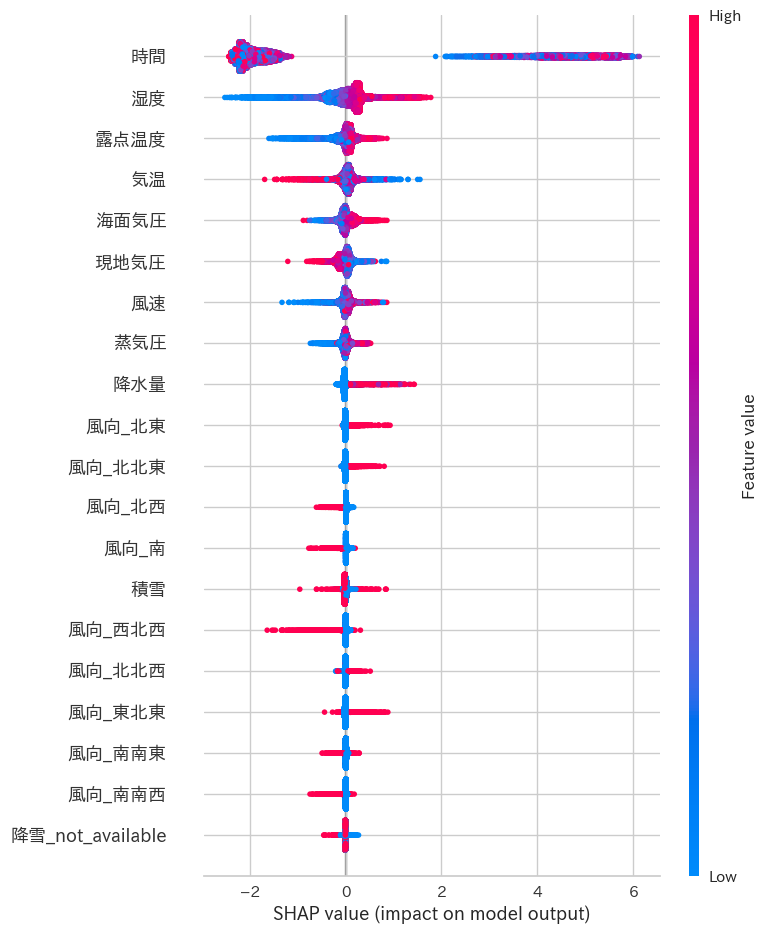

In [28]:
interpret_model(final_lgbm)

In [29]:
lgbm_pred = predict_model(final_lgbm,data=df)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.8057,2.5323,1.5913,0.8119,0.4094,1.3163


In [30]:
pred = predict_model(final_lgbm,data=test)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.8677,3.0675,1.7514,0.7720,0.4416,1.6482


In [32]:
pred["日付"] = test_date

In [34]:
pred["diff"] = pred["雲量"] - pred["Label"]

In [45]:
pred.to_csv("./data/csv/forecastCloud.csv",index=False)

In [36]:
pred[pred["diff"].apply(lambda x: abs(x)) >= 6]

,時間,現地気圧,海面気圧,降水量,気温,露点温度,蒸気圧,湿度,風速,風向,降雪,積雪,天気,雲量,Label,日付,diff
8,9,1015.6,1018.6,0.0,5.7,-1.0,5.7,62.0,1.2,北東,0.0,0.0,0,0.0,6.330508,2020-01-03 09:00:00,-6.330508
2,3,1011.6,1014.6,0.0,4.6,-0.4,5.9,70.0,1.5,北北東,0.0,0.0,0,0.0,6.034748,2020-01-04 03:00:00,-6.034748
8,9,1018.5,1021.5,0.0,5.7,-1.4,5.5,60.0,3.6,北西,0.0,0.0,0,0.5,7.805852,2020-01-05 09:00:00,-7.305852
20,21,994.2,997.1,0.0,5.5,5.5,9.0,100.0,1.4,北西,0.0,0.0,0,0.5,7.009123,2020-01-08 21:00:00,-6.509123
20,21,1015.2,1018.2,0.0,7.7,1.8,6.9,66.0,2.7,東,0.0,0.0,0,1.0,7.967227,2020-01-10 21:00:00,-6.967227
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2,3,1004.0,1007.0,0.0,6.3,-1.1,5.6,59.0,1.9,北西,0.0,0.0,0,10.0,3.425397,2022-12-22 03:00:00,6.574603
14,15,985.9,988.8,0.0,10.4,8.8,11.4,90.0,1.3,南南東,0.0,0.0,0,2.0,8.798609,2022-12-22 15:00:00,-6.798609
17,18,984.6,987.5,0.0,9.3,8.7,11.2,96.0,3.5,南南東,0.0,0.0,0,0.5,8.514226,2022-12-22 18:00:00,-8.014226
14,15,1016.3,1019.2,0.0,11.0,1.3,6.7,51.0,2.0,南東,0.0,0.0,0,0.5,6.506197,2022-12-28 15:00:00,-6.006197
